# Seed for Repoducibility

In [1]:
import hashlib
import string
import random
def get_reproducible_seeds(name="ProjectLong",nb_seeds=100):
    # Calculate SHA-256 hash
    sha256_hash = hashlib.sha256(name.encode()).hexdigest()
    # Define character sets
    digits = string.digits
    # Use the hash to seed the random number generator
    hash_as_int = int(sha256_hash, 16)
    random.seed(hash_as_int)
    # Generate a random list of seed of desired length
    reproducibility_seeds = [random.randint(0,10000) for _ in range(nb_seeds)]

    return reproducibility_seeds

In [2]:
reproducibility_seed=get_reproducible_seeds()[0]

# Small Dataset (15 days)

In [ ]:
!wget http://sguangwang.com/dataset/telecom.zip
!unzip /content/telecom.zip


--2024-02-12 13:26:44--  http://sguangwang.com/dataset/telecom.zip
Resolving sguangwang.com (sguangwang.com)... 182.50.151.114
Connecting to sguangwang.com (sguangwang.com)|182.50.151.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53432897 (51M) [application/x-zip-compressed]
Saving to: ‘telecom.zip’

telecom.zip         100%[===================>]  50.96M  12.2MB/s    in 5.0s    

2024-02-12 13:26:50 (10.3 MB/s) - ‘telecom.zip’ saved [53432897/53432897]

Archive:  /content/telecom.zip
  inflating: dataset-telecom/data_6.1~6.30_.xlsx  


In [ ]:
import pandas as pd
df=pd.read_excel("/content/dataset-telecom/data_6.1~6.30_.xlsx")
df.to_pickle("telecom_data.pkl")

## Prediction

### Prepocessing

In [ ]:
import torch
import numpy as np
import pandas as pd
df= pd.read_pickle("telecom_data.pkl")
df=df.sort_values('start time')
def get_x(value):
    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value
def get_y(value):
    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

df['x'] = df['location(latitude/lontitude)'].apply(get_x)
df['y'] = df['location(latitude/lontitude)'].apply(get_y)
df['x_normalised']=(df['x']-df['x'].mean())/(df['x'].std())
df['y_normalised']=(df['y']-df['y'].mean())/df['y'].std()
df['pos']= list(zip(df['x'],df['y']))

import math
pos=df['pos'].unique()
vocab=dict(zip(pos,range(len(pos))))
vocab[(float('nan'),float('nan'))]=len(vocab)
def tokenize_pos(pos):
  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]
df['pos_id'] = df['pos'].apply(tokenize_pos)

#create encoded time series
min_year = df["start time"].dt.year.min()
max_year = df["start time"].dt.year.max()
df['year_normalised'] = (df["start time"].dt.year - min_year) / (max_year - min_year)

df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)

df['time_to_end']=df['end time']-df['start time']
df['time_to_end']=df['time_to_end'].dt.total_seconds()

df=df.drop(['month', 'date', 'end time', 'location(latitude/lontitude)', 'x', 'y','pos'], axis=1)
df_user_group = df.groupby('user id')
list_users=[]
for user, df_user in df_user_group:
  if len(df_user)>=2:
    df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
    dict_user=df_user.to_dict('list')
    dict_user["time_to_next"][-1]=-1.
    dict_user["pos_id"]=torch.tensor(dict_user["pos_id"]+[len(vocab)+1])

    dict_user["pos_id_target"]=dict_user["pos_id"][1:]
    dict_user["pos_id"]=dict_user["pos_id"][:-1]
    dict_user["input"]=torch.tensor([dict_user["x_normalised"],dict_user["y_normalised"],dict_user['month_sin'], dict_user['month_cos'], dict_user['day_sin'], dict_user['day_cos'], dict_user['hour_sin'], dict_user['hour_cos'], dict_user['minute_sin'], dict_user['minute_cos'], dict_user['second_sin'], dict_user['second_cos']]).T
    #print(dict_user["input"].shape,dict_user["input"].T.shape)
    dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
    j=1
    i=0
    while i < dict_user["input"].size(0) and torch.isnan(dict_user["input"][i,j]):
      i+=1
    if i < dict_user["input"].size(0):
      dict_user["input"][:i,0]=dict_user["input"][i,0]
      dict_user["input"][:i,1]=dict_user["input"][i,1]
      nan_positions = torch.isnan(dict_user["input"])
      # Step 2: Replace NaN values with the values from the preceding row of the same column
      for i in range(i+1, dict_user["input"].size(0)):
        dict_user["input"][i, nan_positions[i]] = dict_user["input"][i - 1, nan_positions[i]]

      for e in ['x_normalised', 'y_normalised','year_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'time_to_end', 'time_to_next','start time', 'user id']:
        dict_user.pop(e)
      list_users.append(dict_user)
time_targets=torch.cat([dict_user["time_target"] for dict_user in list_users],dim=0)
time_targets_mean=time_targets.mean(dim=0)
time_targets_std=time_targets.std(dim=0)

for i in range(len(list_users)):
  list_users[i]["time_target"]=(list_users[i]["time_target"]-time_targets_mean)/time_targets_std
torch.save(list_users,"list_users")
torch.save(vocab,'vocab')

In [3]:
import torch
list_users=torch.load("list_users")
vocab= torch.load('vocab')

### Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDataset(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id_target'], user_dict['time_target']

dataset=VariableLengthDataset(list_users)

In [ ]:
dataset.__getitem__(0)[0].shape

torch.Size([14, 12])

In [ ]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))

    ## compute mask
    mask_time_targets = (time_targets != -1)
    return inputs, time_targets, pos_ids, lengths, mask_time_targets
dataloader=DataLoader(dataset,batch_size=64,collate_fn=collate_fn_padd,shuffle=True)

In [ ]:
next(iter(dataloader))

### Classic Training


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs=17
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters())
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
      loss_regression = (loss_regression * mask_time_targets.float()).mean()
      loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)


epoch: 0 loss: 18.840499846140542
epoch: 1 loss: 18.608480728997126
epoch: 2 loss: 18.47722815407647
epoch: 3 loss: 19.080203787485758
epoch: 4 loss: 18.70116665098402
epoch: 5 loss: 18.936610984802247
epoch: 6 loss: 18.500861348046197
epoch: 7 loss: 19.131100294325087
epoch: 8 loss: 18.758988920847575
epoch: 9 loss: 18.878969764709474
epoch: 10 loss: 18.871430248684355
epoch: 11 loss: 18.270792081620957
epoch: 12 loss: 18.589879290262857
epoch: 13 loss: 18.64937384923299
epoch: 14 loss: 18.908659415774874


### Sequencing Classification and regression

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
lr=0.001
epochs=epochs_complete_problem+ epochs_classifcation_only
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters(),lr=lr)
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      if epoch>=epochs_classifcation_only:
        loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
      else:
        loss=loss_classification
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

epoch: 0 loss: 7.769814189275106
epoch: 1 loss: 7.688149589962429
epoch: 2 loss: 7.681943141089546
epoch: 3 loss: 7.677431223127577
epoch: 4 loss: 7.672929933336046
epoch: 5 loss: 7.673284302817451
epoch: 6 loss: 7.6768125428093805
epoch: 7 loss: 7.67123220761617
epoch: 8 loss: 7.660207096735636
epoch: 9 loss: 7.653950717714098
epoch: 10 loss: 18.43856125937568
epoch: 11 loss: 18.592761262257895
epoch: 12 loss: 18.74313888549805
epoch: 13 loss: 18.691165171729192
epoch: 14 loss: 18.619252024756538
epoch: 15 loss: 18.730495770772297
epoch: 16 loss: 18.771625094943577
epoch: 17 loss: 18.628106456332738
epoch: 18 loss: 18.654819912380642
epoch: 19 loss: 18.703358374701605


### Modified architecture

In [ ]:
class LSTM_Classification_regression(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,num_layers,batch_first=True):
    super().__init__(self)
    self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
  def forward(self,x,reg=True):
    x,_=self.lstm(x)
    x=F.relu(x)
    if reg:
      return self.classifier(x),self.linear_reg(x)
    else:
      return self.classifier(x)



NameError: name 'nn' is not defined

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
input_size=12
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size
epochs=epochs_complete_problem+ epochs_classifcation_only
model=LSTM_Classification_regression(input_size, hidden_size,output_regression_size,output_classfication_size,num_layers).cuda()

optimizer_encoder = optim.Adam(encoder.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for x, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    batch_size=x.shape[0]
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,reg=False)
        x=pad_packed_sequence(torch.nn.utils.rnn.PackedSequence(out, batch_size), batch_first=True)
        loss=criterion_classification(x.transpose(1,2),pos_ids)
      else:
        x,y=model(x,reg=True)
        loss_classification=criterion_classification(x.transpose(1,2),pos_ids)
        loss_regression=criterion_regression(F.relu(y),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

### Embeddings


#### New Dataset with  current pos_id

In [4]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id'],user_dict['pos_id_target'], user_dict['time_target']
def create_dataset(list_users,split=[0.8,0.1,0.1]):
  dataset=VariableLengthDatasetWithPosID(list_users)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
  return dataset_list


In [ ]:
len(dataset.times_series)

NameError: name 'dataset' is not defined

In [5]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,pos_id_targets,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))
    pos_id_targets = torch.nn.utils.rnn.pad_sequence(pos_id_targets,batch_first=True,padding_value=len(vocab))


    return inputs, pos_ids, time_targets, pos_id_targets, lengths



#### Modified Model with embeddings

In [ ]:
dataset_list=create_dataset(list_users)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=32,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)

In [ ]:
import torch.nn as nn
import torch
from torch.nn import Embedding, LSTM
import torch.nn.functional as F

class LSTM_Classification_regression_Embeddings(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers,batch_first=True):
    super().__init__()
    self.lstm = LSTM(input_size=input_size+embedding_dim, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
    self.embeddings=nn.Embedding(num_embeddings=output_classfication_size,embedding_dim=embedding_dim)

  def forward(self,x,pos_id,lengths,reg=True):
    #BEFORE: x.shape=(batch_size, max_sequence_length,input_size); pos_id.shape=(batch_size,max_sequence_length)
    x=torch.cat([x,self.embeddings(pos_id)],dim=2)
    #AFTER: x.shape=(batch_size, max_sequence_length, input_size+embedding_dim)
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    # x.data.shape=([length_i for i in range(batch_size)].sum(),input_size+embedding_dim)
    x,_=self.lstm(x)
    data=F.relu(x.data)
    if reg:
      x = torch.nn.utils.rnn.PackedSequence(self.classifier(data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      y = torch.nn.utils.rnn.PackedSequence(torch.exp(self.linear_reg(data)), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      return x,y
    else:
      return  torch.nn.utils.rnn.PackedSequence(self.classifier(data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)

In [ ]:
def evaluate(model,dataloader,criterion_classification,criterion_regression):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    for x, pos_ids, time_targets, target_pos_ids, lengths in dataloader:
      batch_size=x.shape[0]
      x=x.float().cuda()
      pos_ids=pos_ids.cuda()
      time_targets = time_targets.cuda()
      target_pos_ids = target_pos_ids.cuda()
      with autocast(device_type="cuda"):
        x,y=model(x,pos_ids,lengths,reg=True)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        time_targets=torch.nn.utils.rnn.pack_padded_sequence(time_targets, lengths=lengths,batch_first=True, enforce_sorted=False)
        ## compute mask
        mask_time_targets = (time_targets.data != -1)
        loss_classification=criterion_classification(x.data,target_pos_ids.data)
        acc+=(x.data.argmax(dim=1)==target_pos_ids.data).sum()
        nb_points+=x.data.shape[0]
        loss_regression=criterion_regression(y.data,time_targets.data)
        loss_regression = (loss_regression * mask_time_targets.data.float()).mean()
        loss=loss_classification+loss_regression
    return acc.item()/(nb_points),loss_classification.item()/len(dataloader),loss_regression.item()/len(dataloader)


In [ ]:
print(len(valid_dataloader)*10)

580


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
## parameters
#training params
epochs_classifcation_only=10
epochs_complete_problem =20
epochs=epochs_complete_problem+ epochs_classifcation_only
#Model params
input_size=12
embedding_dim=400
num_layers=4
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size

model=LSTM_Classification_regression_Embeddings(input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers).cuda()
optimizer_encoder = optim.Adam(model.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
valid_accs=[]
valid_losses_classification=[]
valid_losses_regression=[]
for epoch in range(epochs):
  model.train()
  epoch_losses=[]
  for x, pos_ids, time_targets, target_pos_ids, lengths in train_dataloader:
    optimizer_encoder.zero_grad()
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    time_targets = time_targets.cuda()
    #print(target_pos_ids)
    target_pos_ids = target_pos_ids.cuda()
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,pos_ids,lengths,reg=False)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        loss=criterion_classification(x.data,target_pos_ids.data)
      else:
        x,y=model(x,pos_ids,lengths,reg=True)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(target_pos_ids, lengths=lengths,batch_first=True, enforce_sorted=False)
        time_targets=torch.nn.utils.rnn.pack_padded_sequence(time_targets, lengths=lengths,batch_first=True, enforce_sorted=False)
        mask_time_targets = (time_targets.data != -1)
        loss_classification=criterion_classification(x.data,target_pos_ids.data)
        loss_regression=criterion_regression(y.data,time_targets.data)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression

    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  train_losses.append(loss_epoch)
  valid_acc,valid_loss_classification,valid_loss_regression=evaluate(model,valid_dataloader,criterion_classification,criterion_regression)
  valid_accs.append(valid_acc)
  valid_losses_classification.append(valid_loss_classification)
  valid_losses_regression.append(valid_loss_regression)
  print("epoch: "+str(epoch)+" train loss: "+str(loss_epoch)+" valid_acc: "+str(valid_acc)," valid_loss_classification: "+str(valid_loss_classification)+" valid_loss_regression: "+str(valid_loss_regression))

epoch: 0 train loss: 6.551205036375258 valid_acc: 0.32183010877688284  valid_loss_classification: 1.5915258725484211 valid_loss_regression: 0.6874008178710938
epoch: 1 train loss: 3.7312705331378515 valid_acc: 0.46981649090758115  valid_loss_classification: 1.0163533687591553 valid_loss_regression: 0.6963268915812174
epoch: 2 train loss: 2.6541660997602676 valid_acc: 0.533654405048576  valid_loss_classification: 0.7919421195983887 valid_loss_regression: 0.6965961456298828
epoch: 3 train loss: 2.204934208922916 valid_acc: 0.5659387195881425  valid_loss_classification: 0.7073539892832438 valid_loss_regression: 0.7110209465026855
epoch: 4 train loss: 1.986035825146569 valid_acc: 0.5732790832848957  valid_loss_classification: 0.6577861309051514 valid_loss_regression: 0.6914376417795817
epoch: 5 train loss: 1.838186095820533 valid_acc: 0.5850369509258491  valid_loss_classification: 0.6108259359995524 valid_loss_regression: 0.6918560663859049
epoch: 6 train loss: 1.7388380103641086 valid_acc

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

### Transfomers

Split Long-sequences

In [6]:
def split_long_sequences(list_users,max_sequence_length):
  new_list_users=[]
  for i in range(len(list_users)):
    #print(i)
    seq_length=list_users[i]["input"].shape[0]
    if seq_length>=max_sequence_length:
      div=2
      while max_sequence_length/div >= max_sequence_length:
        div+=1
      new_seq_length=seq_length//div
      list_splitted_seq=div*[{}]
      for key in list_users[i]:
        for j in range(div):
          if j!=div-1:
            list_splitted_seq[j][key]=list_users[i][key][div*j:div*(j+1)]
          else:
            list_splitted_seq[j][key]=list_users[i][key][div*j:]
      new_list_users+list_splitted_seq
    else:
      new_list_users.append(list_users[i])
  return new_list_users

splitted_list_user=split_long_sequences(list_users,500)

In [7]:
dataset_list=create_dataset(splitted_list_user)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=32,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=128,collate_fn=collate_fn_padd,shuffle=False)

In [17]:
import torch.nn as nn
from torch import nn, Tensor
import math
def get_mask(bath_size,sequence_length,lengths):
  mask=torch.zeros(bath_size,sequence_length).cuda()
  for i, length in enumerate(lengths):
    mask[i,length:]=1
  return mask.bool()
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = (x.transpose(0,1) + self.pe[:x.transpose(0,1).size(0)]).transpose(0,1)
        return self.dropout(x)

class Transformer_Classification_regression(nn.Module):

  def __init__(self,embedding_dim,d_model,output_classfication_size,output_regression_size,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
    super().__init__()

    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.linear_reg=nn.Linear(d_model,output_regression_size)
    self.classifier=nn.Linear(d_model,output_classfication_size)
    self.embedding=nn.Embedding(num_embeddings=output_classfication_size,embedding_dim=embedding_dim)
    self.init_weights()
    self.d_model=d_model
  def init_weights(self) -> None:
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.classifier.bias.data.zero_()
    self.classifier.weight.data.uniform_(-initrange, initrange)

  def forward(self,x,pos_id,lengths,reg=True):
    torch.autograd.set_detect_anomaly(True)
    x=torch.cat([x,self.embedding(pos_id)],dim=2)* math.sqrt(self.d_model)
    #print(x[0,:,0])

    self.pos_encoder(x)
    with torch.no_grad():
      mask_x = get_mask(x.shape[0],x.shape[1],lengths)
      causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device= torch.device('cuda'))
    #print(mask_x[0])
    #print("before transformers: ", torch.isnan(x).sum())
    x=self.transformer_encoder( x,
                        mask = causal_mask,
                        src_key_padding_mask = mask_x,
                        is_causal = True)
    #print("after: ",torch.isnan(x).sum())
    #print(x[0,:,0])
    x=F.relu(x)
    #print(x.shape,mask_x.shape)
    #del mask_x
    del causal_mask

    if reg:
      return self.classifier(x),torch.exp(self.linear_reg(x))
    else:
      return  self.classifier(x)

In [9]:
def evaluate(model,dataloader,criterion_classification,criterion_regression):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    for x, pos_ids, time_targets, target_pos_ids, lengths in dataloader:
      x=x.float().cuda()
      pos_ids=pos_ids.cuda()
      time_targets = time_targets.cuda()
      target_pos_ids = target_pos_ids.cuda()
      with autocast(device_type="cuda"):
        x,y=model(x,pos_ids,lengths,reg=True)
        mask_time_targets = (time_targets != -1)
        loss_classification=criterion_classification(x.transpose(1,2),target_pos_ids)
        acc+=((target_pos_ids!=len(vocab))*(x.argmax(dim=2)==target_pos_ids)).sum()
        nb_points+=lengths.sum()
        loss_regression=criterion_regression(y,time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression

    return acc.item()/(nb_points),loss_classification.item()/len(dataloader),loss_regression.item()/len(dataloader)

In [ ]:
len(vocab)+2

2773

In [29]:
torch.cuda.memory_allocated()

1846327808

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
import numpy as np

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.autograd.set_detect_anomaly(True)
## parameters
#training params

epochs_classifcation_only=20
epochs_complete_problem =10
epochs=epochs_complete_problem+ epochs_classifcation_only
#Model params
nhead=10
num_layers=2
d_model=2780

input_size=12
output_regression_size=2
output_classfication_size=len(vocab)+2
embedding_dim=d_model-input_size

model=Transformer_Classification_regression(embedding_dim,
                                            d_model,
                                            output_classfication_size,
                                            output_regression_size,
                                            num_layers,
                                            nhead
                                            ).cuda()
lr=5e-4
optimizer_encoder = optim.Adam(model.parameters(),lr=lr)

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index = len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction = 'none')

train_losses=[]
valid_accs=[]
valid_losses_classification=[]
valid_losses_regression=[]
for epoch in range(epochs):
  model.train()
  epoch_losses=[]
  for x, pos_ids, time_targets, target_pos_ids, lengths in train_dataloader:

    optimizer_encoder.zero_grad()
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    target_pos_ids = target_pos_ids.cuda()

    with autocast(device_type="cuda"):

      if epoch<epochs_classifcation_only:
        #print(torch.isnan(x).sum())
        x=model(x,pos_ids,lengths,reg=False)
        #print(torch.isnan(x).sum())
        loss=criterion_classification(x.transpose(1,2),target_pos_ids)
        #print(loss)
        #break
      else:
        time_targets = time_targets.cuda()
        x,y=model(x,pos_ids,lengths,reg=True)
        mask_time_targets = (time_targets != -1)
        loss_classification=criterion_classification(x.transpose(1,2),target_pos_ids)
        loss_regression=criterion_regression(y,time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())

    del loss
    del x
    del pos_ids
    del target_pos_ids
  #break
  loss_epoch=np.mean(epoch_losses)
  train_losses.append(loss_epoch)

  valid_acc,valid_loss_classification,valid_loss_regression=evaluate(model,valid_dataloader,criterion_classification,criterion_regression)
  valid_accs.append(valid_acc)
  valid_losses_classification.append(valid_loss_classification)
  valid_losses_regression.append(valid_loss_regression)
  print("epoch: "+str(epoch)+" train loss: "+str(loss_epoch)+" valid_acc: "+str(valid_acc)," valid_loss_classification: "+str(valid_loss_classification)+" valid_loss_regression: "+str(valid_loss_regression))

epoch: 0 train loss: 8.239769121983668 valid_acc: tensor(0.0129)  valid_loss_classification: 1.5951584815979003 valid_loss_regression: 0.12317827939987183
epoch: 1 train loss: 6.946030696788868 valid_acc: tensor(0.1128)  valid_loss_classification: 1.3558566093444824 valid_loss_regression: 0.12690681219100952
epoch: 2 train loss: 5.482921546989387 valid_acc: tensor(0.1789)  valid_loss_classification: 1.1733293533325195 valid_loss_regression: 0.12059834003448486
epoch: 3 train loss: 4.392017831335535 valid_acc: tensor(0.1999)  valid_loss_classification: 1.0548426628112793 valid_loss_regression: 0.12448951005935668
epoch: 4 train loss: 3.7885432810216515 valid_acc: tensor(0.2310)  valid_loss_classification: 1.0873330116271973 valid_loss_regression: 0.11788644790649414
epoch: 5 train loss: 3.5132322478127644 valid_acc: tensor(0.2430)  valid_loss_classification: 0.9962759017944336 valid_loss_regression: 0.13220565319061278
epoch: 6 train loss: 3.200424827895798 valid_acc: tensor(0.2613)  va

In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [26]:
del model

In [24]:
del optimizer_encoder
#del model
del x


In [25]:
del loss

del pos_ids
del target_pos_ids

In [ ]:
with torch.no_grad():
  model.eval()
  for x, pos_ids, time_targets, target_pos_ids, lengths in train_dataloader:
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    time_targets = time_targets.cuda()
    target_pos_ids = target_pos_ids.cuda()
    with autocast(device_type="cuda"):
        x,y=model(x,pos_ids,lengths,reg=True)
        print(((x.argmax(dim=2)==target_pos_ids))[0],target_pos_ids)
        break

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
len(vocab)

2771

# XGBoost


## Data Analysis

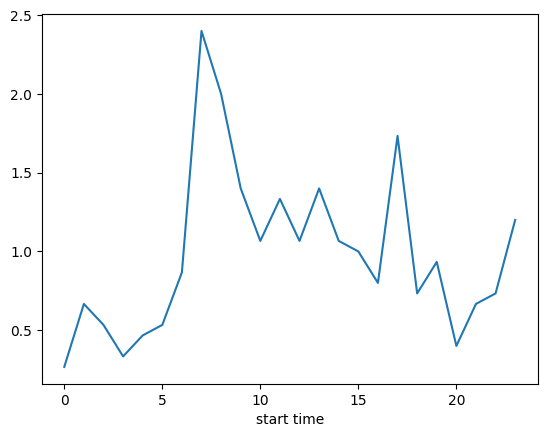

In [ ]:
grouped_id=df_xlsx.groupby('location(latitude/lontitude)')
i=0
for id,df_id in grouped_id:
  #print(id)
  (df_id.groupby([df_id["start time"].dt.hour])["start time"].count()/15).plot()
  i+=1
  break
  if i>=1000:
    break


In [ ]:
dataset_dic=np.load("./TelecomDataset/dataset_dic.npy",allow_pickle=True)

In [ ]:
dataset_dic=delete_overlaps_dataset(dataset_dic)

In [ ]:
dataset_dic, list_id = convervt_id_to_idx(dataset_dic)

In [ ]:
dic_station, list_station=get_dic_station(dataset_dic)

In [ ]:
dataset_dic=add_class(dataset_dic,dic_station)

In [ ]:
idx=2
start_times=dataset_dic[idx]["start time"]
end_times=dataset_dic[idx]["end time"]
nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15)
nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15)

In [ ]:
print(nb_time_step_connections,nb_time_step_btwn_connections)

In [ ]:
mean=get_mean_connect_time(dataset_dic)

In [ ]:
print((dataset_dic[2]['end time'][0]-dataset_dic[2]['start time'][0]).astype('timedelta64[m]'))


22 minutes


In [ ]:
import numpy as np
np.arange(100).reshape(10,10).reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
def blank_name(dataset_dic,idx)
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15).int()
    nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15).int()
    repmat(


In [ ]:

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, dataset_dic, input_sequence_len, output_size=1, nan_started=0, nan_stopped=0, missing_indices=np.array([])):
        self.data = dataset_dic
        self.input_sequence_len = input_sequence_len
        self.output_size = output_size
        self.nan_started = nan_started
        self.missing_data_len = nan_stopped - nan_started
        self.missing_indices = missing_indices

    def __len__(self):
        return len(self.data) - 2*self.input_sequence_len - 2*self.output_size - self.missing_data_len

    def __getitem__(self, idx):
        self.data =
        dic_idx= self.data[idx]
        =dic_idx['start time']
        stop_sequence_idx = start_idx + self.input_sequence_len
        stop_target_idx = stop_sequence_idx + self.output_size
        # If considered sequence intersects with the missing value list [11122, .... ,11133]
        # jump to 11134 index
        if np.intersect1d(np.arange(start_idx, stop_target_idx), self.missing_indices).size > 0:
          start_idx = self.missing_indices[-1] + 1

        # Avoid the missing data range
        if stop_target_idx >= self.nan_started :
            start_idx += self.missing_data_len + self.input_sequence_len + self.output_size
            stop_sequence_idx = start_idx + self.input_sequence_len
            stop_target_idx = stop_sequence_idx + self.output_size
        # Extracting a sequence of data
        # YOUR CODE HERE
        assert sequence.shape[0] == self.input_sequence_len
        assert target.shape[0] == self.output_size
        return {'sequence': torch.Tensor(sequence), 'target': torch.Tensor(target)}

NameError: ignored

In [ ]:
nb=0
nb2=0
nb3=0
nb4=0
for id in dataset_dic:
  dic_id=dataset_dic[id]
  startarray=dic_id['start time']
  endarray=dic_id['end time']
  lattitude_array=dic_id['latitude']
  for i in range(len(startarray)-1):
    if startarray[i]>endarray[i]:
      nb4+=0
      print("element :"+str(i)+" of id: "+id)
    if startarray[i+1]<endarray[i]:
      nb+=1
    else:
      nb2+=1
    if startarray[i+1]<endarray[i] and lattitude_array[i]!=lattitude_array[i+1]:
      nb3+=1
    if startarray[i+1]<startarray[i]:
      nb+=0
      print("not sorted")
print(nb,nb2,nb3,nb4)


0 6943182 0 0


KeyError: ignored

In [ ]:
nb4

0

In [ ]:
import numpy as np
df=df.loc[np.isnan(df['latitude'])==False]
print(df)

df['month'] = df["start time"].dt.month
df['day'] = df["start time"].dt.day
df['hour'] = df["start time"].dt.hour
df['minute'] = df["start time"].dt.minute
df['second'] = df["start time"].dt.second
df['year'] = df["start time"].dt.year

df_encoded = df

df_encoded['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df_encoded['day_sin'] = np.sin(2 * np.pi * df['hour'] / 31)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['hour'] / 31)

df_encoded['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df_encoded['minute_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['minute_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

df_encoded['second_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['second_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

# Normalise the temperatures into a range of [0, 1],
# to ensure that all input features are on a similar scale
min_latitude = df_encoded['latitude'].min()
max_latitude = df_encoded['latitude'].max()
df_encoded['latitude'] = (df_encoded['latitude'] - min_latitude) / (max_latitude - min_latitude)

min_latitude = df_encoded['longitude'].min()
max_latitude = df_encoded['longitude'].max()
df_encoded['longitude'] = (df_encoded['longitude'] - min_latitude) / (max_latitude - min_latitude)

# Remove unused columns
columns_to_drop = ['year','month','hour','second','minute','date']
df_encoded = df_encoded.drop(columns=columns_to_drop, axis=1)
df_encoded

        month  date          start time            end time   latitude  \
205        10    16 2014-10-16 11:44:35 2014-10-16 11:53:03  31.246946   
206        10    16 2014-10-16 12:08:07 2014-10-16 12:18:56  31.246946   
207        10    16 2014-10-16 08:59:32 2014-10-16 11:00:51  31.246946   
208        10    16 2014-10-16 14:29:49 2014-10-16 14:43:32  31.246946   
209        10    16 2014-10-16 16:08:41 2014-10-16 16:11:17  31.246946   
...       ...   ...                 ...                 ...        ...   
575569     10    31 2014-10-31 14:57:37 2014-10-31 15:01:11  31.087196   
575570     10    31 2014-10-31 14:46:40 2014-10-31 14:48:38  31.087196   
575571     10    31 2014-10-31 15:12:59 2014-10-31 15:14:27  31.087196   
575572     10    31 2014-10-31 16:59:06 2014-10-31 17:00:30  31.087196   
575573     10    31 2014-10-31 15:17:47 2014-10-31 15:19:46  31.087196   

        longitude                           user id  day  hour  minute  ...  \
205      0.654516  b6f11a26170aa

,start time,end time,latitude,longitude,user id,day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,latitute
205,2014-10-16 11:44:35,2014-10-16 11:53:03,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.790776,-0.612106,2.588190e-01,-0.965926,0.913545,4.067366e-01,0.913545,4.067366e-01,0.359689
206,2014-10-16 12:08:07,2014-10-16 12:18:56,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.651372,-0.758758,1.224647e-16,-1.000000,0.951057,3.090170e-01,0.951057,3.090170e-01,0.359689
207,2014-10-16 08:59:32,2014-10-16 11:00:51,0.359689,0.654516,c150c622280f1d6e32dd45e7c59ed751,16,-0.866025,0.5,0.998717,-0.050649,8.660254e-01,-0.500000,0.743145,6.691306e-01,0.743145,6.691306e-01,0.359689
208,2014-10-16 14:29:49,2014-10-16 14:43:32,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.359689
209,2014-10-16 16:08:41,2014-10-16 16:11:17,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.359689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575569,2014-10-31 14:57:37,2014-10-31 15:01:11,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575570,2014-10-31 14:46:40,2014-10-31 14:48:38,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575571,2014-10-31 15:12:59,2014-10-31 15:14:27,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.101168,-0.994869,-7.071068e-01,-0.707107,1.000000,2.832769e-16,1.000000,2.832769e-16,0.353103
575572,2014-10-31 16:59:06,2014-10-31 17:00:30,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.353103


In [ ]:
import numpy as np
np.float64("Nan")

nan

In [ ]:
df.loc[np.isnan(df['latitude'])==False]

,month,date,start time,end time,latitude,longitude,user id
205,201410,16,2014-10-16 11:44:35,2014-10-16 11:53:03,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
206,201410,16,2014-10-16 12:08:07,2014-10-16 12:18:56,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
207,201410,16,2014-10-16 08:59:32,2014-10-16 11:00:51,31.246946,121.513919,c150c622280f1d6e32dd45e7c59ed751
208,201410,16,2014-10-16 14:29:49,2014-10-16 14:43:32,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
209,201410,16,2014-10-16 16:08:41,2014-10-16 16:11:17,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
...,...,...,...,...,...,...,...
575569,201410,31,2014-10-31 14:57:37,2014-10-31 15:01:11,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575570,201410,31,2014-10-31 14:46:40,2014-10-31 14:48:38,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575571,201410,31,2014-10-31 15:12:59,2014-10-31 15:14:27,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575572,201410,31,2014-10-31 16:59:06,2014-10-31 17:00:30,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df


# Big Dataset (6 month)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi" -O dataset_telecom.zip && rm -rf /tmp/cookies.txt
!unzip /content/dataset_telecom.zip

--2023-11-27 13:50:54--  https://docs.google.com/uc?export=download&confirm=t&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi
Resolving docs.google.com (docs.google.com)... 172.217.12.14, 2607:f8b0:4025:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j2cqssojvgudttt0dt7h65n2638c7ms/1701093000000/15669009389864827016/*/1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi?e=download&uuid=4919f37d-6ee9-4470-bd11-43a0f0ed72ab [following]
--2023-11-27 13:50:54--  https://doc-0c-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j2cqssojvgudttt0dt7h65n2638c7ms/1701093000000/15669009389864827016/*/1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi?e=download&uuid=4919f37d-6ee9-4470-bd11-43a0f0ed72ab
Resolving doc-0c-1g-docs.googleusercontent.com (doc-0c-1g-docs.googleusercontent.com)... 172.217.12.1, 2607:f8b0:4025:

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

def update_dic(df_id,file_path_id,columnSorting='start time'):
  dic_id=np.load(file_path_id,allow_pickle=True).item()
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def update_dic(df_id,dataset_dic,id):
  dic_id=dataset_dic[id]
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  return dic_id

def sort_dic_id(dic_id,columnSorting='start time'):
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def create_dic(df_id,drop_column=['month','date','user id']):
  dic_id={}
  for name in df_id.columns:
    if name not in drop_column :
      dic_id[name]=df_id[name].to_numpy()
  return dic_id

def extract_data_in_dic(file_path,dataset_dic):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')

  for id,df_id in grouped_id:

    if id in dataset_dic :
      dic_id=update_dic(df_id, dataset_dic,id)
    else:
      dic_id=create_dic(df_id)
    dic_id=sort_dic_id(dic_id,columnSorting='start time')
    dataset_dic[id]=dic_id
  return dataset_dic

def extract_data(file_path):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')
  for id,df_id in grouped_id:
    file_path_id=os.path.join('.','TelecomDataset',id+'.npy')
    if os.path.isfile(file_path_id):
      dic_id=update_dic(df_id, file_path_id)
    else:
      dic_id=create_dic(df_id)
    np.save(file_path_id,dic_id)

dataset_dic={}
os.makedirs("TelecomDataset",exist_ok=True)
for file in os.listdir("."):

    if file.endswith(".xlsx"):
      print(file)
      dataset_dic= extract_data_in_dic(os.path.join(".", file),dataset_dic)
    np.save("./TelecomDataset/dataset_dic.npy",dataset_dic)




data_6.16~6.30.xlsx
data_9.16~9.30.xlsx
data_10.1~10.15.xlsx
data_7.1~7.15.xlsx
data_10.16~10.31.xlsx
data_8.1~8.15.xlsx
data_6.1~6.15.xlsx
data_11.16~11.30.xlsx
data_9.1~9.15.xlsx
data_7.16~7.31.xlsx
data_8.16~8.31.xlsx
data_11.1~11.15.xlsx


In [ ]:
def delete_overlaps_dataset(dataset_dic):
  for id in dataset_dic:
    dic_id=dataset_dic[id]
    dic_id=delete_overlaps_id(dic_id)
    dataset_dic[id]=dic_id
  return dataset_dic

def delete_overlaps_id(dic_id):
  for i in range(len(dic_id['start time'])-1):
    if dic_id['start time'][i+1]<dic_id['end time'][i]:
      dic_id['end time'][i]=dic_id['start time'][i+1]
  return dic_id

def convervt_id_to_idx(dataset_dic):
  dataset_dic_idx={}
  list_id=[]
  for idx,id in enumerate(dataset_dic):
    dataset_dic_idx[idx]=dataset_dic[id]
    list_id.append(id)

  return dataset_dic_idx, list_id
def get_dic_station(dataset_dic):
  dic_station={}
  list_station=[]
  for i in dataset_dic:

    latitudes=dataset_dic[i]["latitude"]
    longitudes=dataset_dic[i]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
        position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
        position=(position[0],np.float64(-1))
      if position in dic_station:
        dic_station[position]["number"]+=1
      else:
        dic_station[position]={}
        dic_station[position]["number"]=1
        list_station.append(position)
        dic_station[position]["idx"]=len(list_station)-1

  return dic_station, list_station
def add_class(dataset_dic,dic_station):
  for idx in dataset_dic:
    latitudes=dataset_dic[idx]["latitude"]
    longitudes=dataset_dic[idx]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
          position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
          position=(position[0],np.float64(-1))
      dataset_dic[idx]["class"]=dic_station[position]["idx"]
  return dataset_dic

def get_mean_connect_time(dataset_dic):
  total_nb=0
  sum=0
  for idx in dataset_dic:
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    total_nb+=len(start_times)
    sum+=(end_times-start_times).sum().astype('timedelta64[s]')

  return sum/total_nb


